# Machine Learning Models on the IDS 2018

In this notebook, deicision tree and random forest based machine learning algorithms are applied
to the ids2018 dataset. Several methods for resolving the class imbalance are tested. Decision
tree algorithms were chosen for their effectiveness and the training time which were better than
other machine learning models. RT and RF based algorithms performed better in the preliminary
experiments


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, average_precision_score, make_scorer, precision_score, accuracy_score, confusion_matrix, recall_score, f1_score, roc_auc_score
from utils_ids2018 import load_sample_dataset_2018
%matplotlib inline
%load_ext autoreload
%autoreload 2

file_path = r"..\CIC-IDS-2018\Processed Traffic Data for ML Algorithms"

attack_labels = {
    0: 'Benign',
    1: 'Bot',
    2: 'Brute Force -Web',
    3: 'Brute Force -XSS',
    4: 'DDOS attack-HOIC',
    5: 'DDOS attack-LOIC-UDP',
    6: 'DDoS attacks-LOIC-HTTP',
    7: 'DoS attacks-GoldenEye',
    8: 'DoS attacks-Hulk',
    9: 'DoS attacks-SlowHTTPTest',
    10: 'DoS attacks-Slowloris',
    11: 'FTP-BruteForce',
    12: 'Infilteration',
    13: 'SQL Injection',
    14: 'SSH-Bruteforce'
}

df = load_sample_dataset_2018(file_path)

Processed 1/10 files.
Processed 2/10 files.
Processed 3/10 files.
Processed 4/10 files.
Processed 5/10 files.
Processed 6/10 files.
Processed 7/10 files.
Processed 8/10 files.
Processed 9/10 files.
Processed 10/10 files.
Creating is_attack column...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1623303 entries, 0 to 1623302
Data columns (total 81 columns):
 #   Column             Non-Null Count    Dtype   
---  ------             --------------    -----   
 0   dst_port           1623295 non-null  float64 
 1   protocol           1623295 non-null  float64 
 2   timestamp          0 non-null        float64 
 3   flow_duration      1623295 non-null  float64 
 4   tot_fwd_pkts       1623295 non-null  float64 
 5   tot_bwd_pkts       1623295 non-null  float64 
 6   totlen_fwd_pkts    1623295 non-null  float64 
 7   totlen_bwd_pkts    1623295 non-null  float64 
 8   fwd_pkt_len_max    1623295 non-null  float64 
 9   fwd_pkt_len_min    1623295 non-null  float64 
 10  fwd_pkt_len_mean   1

## Preparing the Dataset

### Check for invalid values

In [2]:
df = df.drop(columns=['timestamp'])
# Select only numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
# Identify columns with NaN, infinity, or negative values
nan_columns = df[numeric_columns].columns[df[numeric_columns].isna().any()]
inf_columns = df[numeric_columns].columns[np.isinf(df[numeric_columns]).any()]
print("Columns with NaN values:", nan_columns.tolist())
print("Columns with infinite values:", inf_columns.tolist())
# Calculate the percentage of NaN, infinite, and negative values
nan_percentage = df[nan_columns].isna().mean() * 100
# nan_percentage = nan_percentage[nan_percentage > 1]
inf_percentage = df[inf_columns].map(lambda x: np.isinf(x)).mean() * 100
print("Percentage of NaN values in each column:\n", nan_percentage)
print("Percentage of infinite values in each column:\n", inf_percentage)

Columns with NaN values: ['dst_port', 'protocol', 'flow_duration', 'tot_fwd_pkts', 'tot_bwd_pkts', 'totlen_fwd_pkts', 'totlen_bwd_pkts', 'fwd_pkt_len_max', 'fwd_pkt_len_min', 'fwd_pkt_len_mean', 'fwd_pkt_len_std', 'bwd_pkt_len_max', 'bwd_pkt_len_min', 'bwd_pkt_len_mean', 'bwd_pkt_len_std', 'flow_byts_s', 'flow_pkts_s', 'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_tot', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min', 'bwd_iat_tot', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags', 'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_len', 'bwd_header_len', 'fwd_pkts_s', 'bwd_pkts_s', 'pkt_len_min', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_std', 'pkt_len_var', 'fin_flag_cnt', 'syn_flag_cnt', 'rst_flag_cnt', 'psh_flag_cnt', 'ack_flag_cnt', 'urg_flag_cnt', 'cwe_flag_count', 'ece_flag_cnt', 'down_up_ratio', 'pkt_size_avg', 'fwd_seg_size_avg', 'bwd_seg_size_avg', 'fwd_byts_b_avg', 'fwd_pkts_b_avg', 'fwd_blk_rate_a

The percentages of rows with infinite or null values are low so the rows are dropped.

In [3]:
def replace_invalid(df):
    # Select only numeric columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    # Identify columns with NaN, infinite, or negative values
    nan_columns = df[numeric_columns].columns[df[numeric_columns].isna().any()]
    inf_columns = df[numeric_columns].columns[np.isinf(df[numeric_columns]).any()]
    # Drop rows with NaN values (low percentage of NaN values)
    df = df.dropna(axis=0)
    # Drop rows with infinite values (assuming low percentage)
    for col in inf_columns:
        df = df[np.isfinite(df[col])]
    return df

In [4]:
df = replace_invalid(df)

In [5]:
X = df.iloc[:, 0:78]
Y = df[["label", "is_attack", "label_code"]]

X.info()
Y.info()
print(Y.label.value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 1613825 entries, 0 to 1250804
Data columns (total 78 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   dst_port           1613825 non-null  float64
 1   protocol           1613825 non-null  float64
 2   flow_duration      1613825 non-null  float64
 3   tot_fwd_pkts       1613825 non-null  float64
 4   tot_bwd_pkts       1613825 non-null  float64
 5   totlen_fwd_pkts    1613825 non-null  float64
 6   totlen_bwd_pkts    1613825 non-null  float64
 7   fwd_pkt_len_max    1613825 non-null  float64
 8   fwd_pkt_len_min    1613825 non-null  float64
 9   fwd_pkt_len_mean   1613825 non-null  float64
 10  fwd_pkt_len_std    1613825 non-null  float64
 11  bwd_pkt_len_max    1613825 non-null  float64
 12  bwd_pkt_len_min    1613825 non-null  float64
 13  bwd_pkt_len_mean   1613825 non-null  float64
 14  bwd_pkt_len_std    1613825 non-null  float64
 15  flow_byts_s        1613825 non-null  

## Feature Selection

First, the columns with no variance are dropped as they have no impact on the target variables.

In [6]:
stats = X.describe()
std = stats.loc["std"]
features_no_var = std[std == 0.0].index
# Exclude non-numeric columns (e.g., categorical columns) from the features with zero variance
features_no_var_numeric = [col for col in features_no_var if col in X.select_dtypes(include=[np.number]).columns]
print(features_no_var_numeric)

['bwd_psh_flags', 'bwd_urg_flags', 'fwd_byts_b_avg', 'fwd_pkts_b_avg', 'fwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_pkts_b_avg', 'bwd_blk_rate_avg']


In [7]:
X = X.drop(columns=features_no_var)
X = X.drop(columns=['dst_port'])
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1613825 entries, 0 to 1250804
Data columns (total 69 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   protocol           1613825 non-null  float64
 1   flow_duration      1613825 non-null  float64
 2   tot_fwd_pkts       1613825 non-null  float64
 3   tot_bwd_pkts       1613825 non-null  float64
 4   totlen_fwd_pkts    1613825 non-null  float64
 5   totlen_bwd_pkts    1613825 non-null  float64
 6   fwd_pkt_len_max    1613825 non-null  float64
 7   fwd_pkt_len_min    1613825 non-null  float64
 8   fwd_pkt_len_mean   1613825 non-null  float64
 9   fwd_pkt_len_std    1613825 non-null  float64
 10  bwd_pkt_len_max    1613825 non-null  float64
 11  bwd_pkt_len_min    1613825 non-null  float64
 12  bwd_pkt_len_mean   1613825 non-null  float64
 13  bwd_pkt_len_std    1613825 non-null  float64
 14  flow_byts_s        1613825 non-null  float64
 15  flow_pkts_s        1613825 non-null  

### Remove collinear variables

In [8]:
def correlation_feature_selection(df, threshold=0.95):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop)
X = correlation_feature_selection(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1613825 entries, 0 to 1250804
Data columns (total 39 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   protocol           1613825 non-null  float64
 1   flow_duration      1613825 non-null  float64
 2   tot_fwd_pkts       1613825 non-null  float64
 3   tot_bwd_pkts       1613825 non-null  float64
 4   fwd_pkt_len_max    1613825 non-null  float64
 5   fwd_pkt_len_min    1613825 non-null  float64
 6   fwd_pkt_len_mean   1613825 non-null  float64
 7   bwd_pkt_len_max    1613825 non-null  float64
 8   bwd_pkt_len_min    1613825 non-null  float64
 9   bwd_pkt_len_mean   1613825 non-null  float64
 10  flow_byts_s        1613825 non-null  float64
 11  flow_pkts_s        1613825 non-null  float64
 12  flow_iat_mean      1613825 non-null  float64
 13  bwd_iat_tot        1613825 non-null  float64
 14  bwd_iat_mean       1613825 non-null  float64
 15  bwd_iat_std        1613825 non-null  

### Information Gain Selection

In [9]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

def oversample_minority_classes(X, Y, sample_size=1000):
    y=Y["label_code"]
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    # Create a subset of the oversampled data
    X_sample, _, y_sample, _ = train_test_split(X_resampled, y_resampled, train_size=sample_size, stratify=y_resampled, random_state=42)
    return X_sample, y_sample

def information_gain_feature_selection(X, Y, sample_size=1000):
    # Create an oversampled subset of the data
    X_sample, y_sample = oversample_minority_classes(X, Y, sample_size)
    # Create is_attack column based on label_code
    y_sample = (y_sample != 0).astype(int)
    # Perform feature selection on the oversampled subset
    info_gain = mutual_info_classif(X_sample, y_sample)
    info_gain_df = pd.DataFrame({'Feature': X.columns, 'Information Gain': info_gain})
    info_gain_df = info_gain_df.sort_values(by='Information Gain', ascending=False)
    print(info_gain_df)
    selected_features = info_gain_df[info_gain_df['Information Gain'] > 0]['Feature'].tolist()
    return selected_features

# Determine the selected features using the oversampled subset
selected_features = information_gain_feature_selection(X, Y)

# Apply the selected features to the main dataset
X = X[selected_features]

# Display information about the selected features
X.info()

              Feature  Information Gain
32  init_bwd_win_byts          0.085694
7     bwd_pkt_len_max          0.081074
31  init_fwd_win_byts          0.070201
4     fwd_pkt_len_max          0.069049
6    fwd_pkt_len_mean          0.066387
21         bwd_pkts_s          0.064578
1       flow_duration          0.059832
9    bwd_pkt_len_mean          0.055198
10        flow_byts_s          0.052621
24        pkt_len_var          0.048762
11        flow_pkts_s          0.047922
12      flow_iat_mean          0.043255
16        bwd_iat_max          0.042899
17        bwd_iat_min          0.039529
3        tot_bwd_pkts          0.038245
23       pkt_len_mean          0.035147
2        tot_fwd_pkts          0.032598
38           idle_min          0.032000
33   fwd_seg_size_min          0.029679
20         fwd_pkts_s          0.025207
13        bwd_iat_tot          0.021932
8     bwd_pkt_len_min          0.020991
15        bwd_iat_std          0.020353
14       bwd_iat_mean          0.015276


## Split Dataset

The dataset is split into a training set and a testing set with a ratio of 0.8/0.2. The dataset is stratified according to the label to have an equal representation of all classes in the 2 subsets.

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y.label)

In [11]:
Y_train.label.value_counts()

label
Benign                      1070878
DDOS attack-HOIC              55054
DDoS attacks-LOIC-HTTP        46142
DoS attacks-Hulk              37046
Bot                           23007
FTP-BruteForce                15517
SSH-Bruteforce                15007
Infilteration                 12762
DoS attacks-SlowHTTPTest      11223
DoS attacks-GoldenEye          3372
DoS attacks-Slowloris           844
DDOS attack-LOIC-UDP            134
Brute Force -Web                 42
Brute Force -XSS                 22
SQL Injection                    10
Label                             0
Name: count, dtype: int64

In [12]:
Y_test.label.value_counts()

label
Benign                      267720
DDOS attack-HOIC             13763
DDoS attacks-LOIC-HTTP       11536
DoS attacks-Hulk              9261
Bot                           5752
FTP-BruteForce                3879
SSH-Bruteforce                3752
Infilteration                 3190
DoS attacks-SlowHTTPTest      2806
DoS attacks-GoldenEye          843
DoS attacks-Slowloris          211
DDOS attack-LOIC-UDP            34
Brute Force -Web                11
Brute Force -XSS                 5
SQL Injection                    2
Label                            0
Name: count, dtype: int64

In [13]:
benign_percentage = len(Y_train.label[Y_train["label"]=="BENIGN"])/len(Y_train)
print('Percentage of benign samples: %.4f' % benign_percentage)
print(Y_train.is_attack.value_counts())

Percentage of benign samples: 0.0000
is_attack
0    1070878
1     220182
Name: count, dtype: int64


## Machine Learning Classifiers with Default Hyperparameters

### Helper Functions

In [14]:
import joblib

def save_model(model, model_name):
    file_path = f'models/{model_name}.pkl'
    joblib.dump(model, file_path)
    print(f'Model saved to {file_path}')

def load_model(model_name):
    file_path = f'models/{model_name}.pkl'
    model = joblib.load(file_path)
    print(f'Model loaded from {file_path}')
    return model

os.makedirs('models', exist_ok=True)

In [15]:
def plot_confusion_matrix(model_name, Y_true, Y_pred, labels=["Benign", "Attack"]):
    matrix = confusion_matrix(Y_true.is_attack, Y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

def metrics_report(dataset_type, y_true, y_predict, print_avg=True):
    print(f"Classification Report ({dataset_type}):")
    print(classification_report(y_true, y_predict, digits=4))
    accuracy = accuracy_score(y_true, y_predict)
    precision = precision_score(y_true, y_predict, average='weighted')
    recall = recall_score(y_true, y_predict, average='weighted')
    f1 = f1_score(y_true, y_predict, average='weighted')
    auc = roc_auc_score(y_true, y_predict)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("AUC:", auc)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "auc": auc}

def calculate_metrics_by_label(y_true, y_pred, labels):
    results = []
    unique_labels = labels.unique()
    for label in unique_labels:
        indices = labels == label
        accuracy = accuracy_score(y_true[indices], y_pred[indices])
        results.append({
            'Label': label,
            'Accuracy': accuracy,
        })
    return pd.DataFrame(results)

In [16]:
def test_metrics(model_name, model, dataset_type, scaler):
    # Predict and evaluate on the test set
    print(f"{model_name} with {dataset_type} Test Set Performance")
    Y_pred = model.predict(scaler.transform(X_test))
    metrics = metrics_report(f"Test {model_name} ({dataset_type})", Y_test.is_attack, Y_pred)
    plot_confusion_matrix(f"{model_name} ({dataset_type})", Y_test, Y_pred)
    # Calculate metrics by label
    metrics_by_label = calculate_metrics_by_label(Y_test.is_attack, Y_pred, Y_test.label)
    metrics_by_label['Method'] = dataset_type
    print(f"Metrics by Label ({dataset_type}):")
    print(metrics_by_label)
    return metrics, metrics_by_label

In [17]:
def plot_overall_accuracy(metrics):
    methods = ['original', 'random', 'smote', 'adasyn']
    overall_accuracies = []

    # Extract overall accuracy for each method
    for method in methods:
        overall_accuracies.append(metrics[method][0]['accuracy'])

    # Plotting the overall accuracies
    plt.figure(figsize=(10, 6))
    bars = plt.bar(methods, overall_accuracies, color=['blue', 'orange', 'green', 'red'])
    plt.title('Overall Accuracy by Method')
    plt.xlabel('Method')
    plt.ylabel('Accuracy')
    plt.ylim(0.9, 1)
    plt.grid(True)

    # Display the values on each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.3f}', ha='center', va='bottom')

    plt.show()

### Resampling methods

In [18]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

def resample_dataset(X, Y, min_samples, attack_labels, technique='smote'):
    Y = Y.drop(columns=['label'])
    combined = pd.concat([X, Y], axis=1)
    counts = Y['label_code'].value_counts()
    samples_number = {i: max(counts[i], min_samples) for i in np.unique(Y['label_code'])}
    combined_array = combined.values
    y_array = Y['label_code'].values

    if technique == 'random':
        resampler = RandomOverSampler(random_state=42, sampling_strategy=samples_number)
    elif technique == 'smote':
        resampler = SMOTE(random_state=42, sampling_strategy=samples_number, k_neighbors=5)
    elif technique == 'adasyn':
        resampler = ADASYN(random_state=42, sampling_strategy=samples_number)
    else:
        raise ValueError("Invalid resampling technique. Choose 'random', 'smote', or 'adasyn'.")

    resampled_array, y_resampled = resampler.fit_resample(combined_array, y_array)
    X_resampled = resampled_array[:, :-Y.shape[1]]
    Y_resampled = resampled_array[:, -Y.shape[1]:]
    X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
    Y_resampled_df = pd.DataFrame(Y_resampled, columns=Y.columns)
    Y_resampled_df['label'] = Y_resampled_df['label_code'].map(attack_labels)
    Y_resampled_df['label'] = Y_resampled_df['label'].astype('category')
    return X_resampled_df, Y_resampled_df

In [19]:
X_random_train, Y_random_train = resample_dataset(X_train, Y_train, 100000, attack_labels, "random")
X_smote_train, Y_smote_train = resample_dataset(X_train, Y_train, 100000, attack_labels, "smote")
X_adasyn_train, Y_adasyn_train = resample_dataset(X_train, Y_train, 100000, attack_labels, "adasyn")

In [20]:
Y_train.label.value_counts()

label
Benign                      1070878
DDOS attack-HOIC              55054
DDoS attacks-LOIC-HTTP        46142
DoS attacks-Hulk              37046
Bot                           23007
FTP-BruteForce                15517
SSH-Bruteforce                15007
Infilteration                 12762
DoS attacks-SlowHTTPTest      11223
DoS attacks-GoldenEye          3372
DoS attacks-Slowloris           844
DDOS attack-LOIC-UDP            134
Brute Force -Web                 42
Brute Force -XSS                 22
SQL Injection                    10
Label                             0
Name: count, dtype: int64

In [21]:
Y_random_train.label.value_counts()

label
Benign                      1070878
Bot                          100000
Brute Force -Web             100000
Brute Force -XSS             100000
DDOS attack-HOIC             100000
DDOS attack-LOIC-UDP         100000
DDoS attacks-LOIC-HTTP       100000
DoS attacks-GoldenEye        100000
DoS attacks-Hulk             100000
DoS attacks-SlowHTTPTest     100000
DoS attacks-Slowloris        100000
FTP-BruteForce               100000
Infilteration                100000
SSH-Bruteforce               100000
Name: count, dtype: int64

In [22]:
Y_smote_train.label.value_counts()

label
Benign                      1070878
Bot                          100000
Brute Force -Web             100000
Brute Force -XSS             100000
DDOS attack-HOIC             100000
DDOS attack-LOIC-UDP         100000
DDoS attacks-LOIC-HTTP       100000
DoS attacks-GoldenEye        100000
DoS attacks-Hulk             100000
DoS attacks-SlowHTTPTest     100000
DoS attacks-Slowloris        100000
FTP-BruteForce               100000
Infilteration                100000
SSH-Bruteforce               100000
Name: count, dtype: int64

In [23]:
Y_adasyn_train.label.value_counts()

label
Benign                      1070878
DoS attacks-GoldenEye        100148
DoS attacks-Slowloris        100032
Bot                          100016
Brute Force -Web             100011
DDOS attack-LOIC-UDP         100010
DoS attacks-SlowHTTPTest     100005
Brute Force -XSS             100003
FTP-BruteForce               100000
SSH-Bruteforce               100000
DDOS attack-HOIC              99996
DDoS attacks-LOIC-HTTP        99937
DoS attacks-Hulk              99729
Infilteration                 98110
Name: count, dtype: int64

### Scaling with the Standard Scaler

In [24]:
# Original X_train
scaler = StandardScaler()
scaler.fit(X_train)
# Random Oversampling
scaler_random = StandardScaler()
scaler_random.fit(X_random_train)
# SMOTE
scaler_smote = StandardScaler()
scaler_smote.fit(X_smote_train)
# ADASYN
scaler_adasyn = StandardScaler()
scaler_adasyn.fit(X_adasyn_train)

StandardScaler()

### Decision Tree

In [25]:
dt_metrics = {}

In [26]:
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(scaler.transform(X_train), Y_train.is_attack)

DecisionTreeClassifier()

Decision Tree with Original Test Set Performance
Classification Report (Test Decision Tree (Original)):
              precision    recall  f1-score   support

           0     0.9891    0.9929    0.9910    267720
           1     0.9646    0.9469    0.9557     55045

    accuracy                         0.9850    322765
   macro avg     0.9769    0.9699    0.9733    322765
weighted avg     0.9849    0.9850    0.9850    322765

Accuracy: 0.9850138645763946
Precision: 0.984937138181439
Recall: 0.9850138645763946
F1 Score: 0.9849586472628847
AUC: 0.9698743660651067


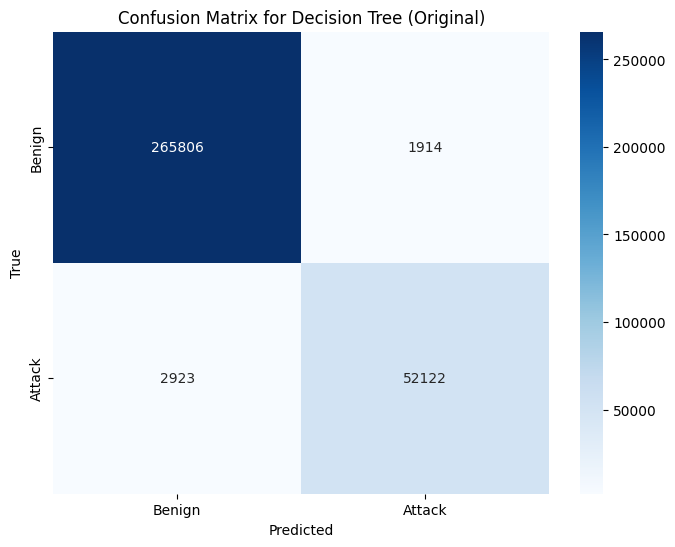

Metrics by Label (Original):
                       Label  Accuracy    Method
0                     Benign  0.992851  Original
1              Infilteration  0.098433  Original
2     DDoS attacks-LOIC-HTTP  0.999480  Original
3   DoS attacks-SlowHTTPTest  1.000000  Original
4           DDOS attack-HOIC  1.000000  Original
5           DoS attacks-Hulk  1.000000  Original
6             FTP-BruteForce  1.000000  Original
7      DoS attacks-Slowloris  0.985782  Original
8             SSH-Bruteforce  0.999733  Original
9      DoS attacks-GoldenEye  1.000000  Original
10                       Bot  0.994089  Original
11      DDOS attack-LOIC-UDP  1.000000  Original
12          Brute Force -XSS  1.000000  Original
13          Brute Force -Web  0.727273  Original
14             SQL Injection  1.000000  Original


In [27]:
# Predict and evaluate on the test set
dt_metrics["original"] = test_metrics("Decision Tree", decision_tree_model, "Original", scaler)

In [28]:
decision_tree_model_random = DecisionTreeClassifier()
decision_tree_model_random.fit(scaler_random.transform(X_random_train), Y_random_train.is_attack)

DecisionTreeClassifier()

Decision Tree with Random Oversampling Test Set Performance
Classification Report (Test Decision Tree (Random Oversampling)):
              precision    recall  f1-score   support

           0     0.9910    0.9831    0.9870    267720
           1     0.9207    0.9564    0.9382     55045

    accuracy                         0.9785    322765
   macro avg     0.9559    0.9697    0.9626    322765
weighted avg     0.9790    0.9785    0.9787    322765

Accuracy: 0.9785261722925348
Precision: 0.9789902785213143
Recall: 0.9785261722925348
F1 Score: 0.9786873035904757
AUC: 0.9697446713694187


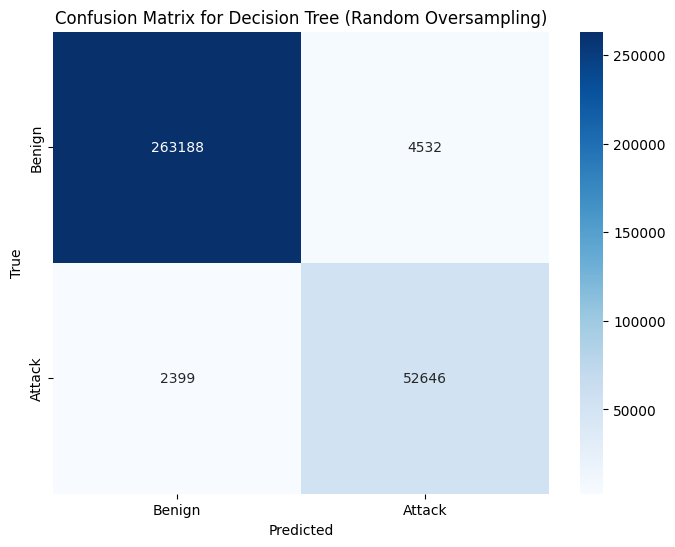

Metrics by Label (Random Oversampling):
                       Label  Accuracy               Method
0                     Benign  0.983072  Random Oversampling
1              Infilteration  0.258934  Random Oversampling
2     DDoS attacks-LOIC-HTTP  0.999827  Random Oversampling
3   DoS attacks-SlowHTTPTest  1.000000  Random Oversampling
4           DDOS attack-HOIC  0.999927  Random Oversampling
5           DoS attacks-Hulk  0.999892  Random Oversampling
6             FTP-BruteForce  1.000000  Random Oversampling
7      DoS attacks-Slowloris  0.985782  Random Oversampling
8             SSH-Bruteforce  0.999733  Random Oversampling
9      DoS attacks-GoldenEye  0.997628  Random Oversampling
10                       Bot  0.996523  Random Oversampling
11      DDOS attack-LOIC-UDP  1.000000  Random Oversampling
12          Brute Force -XSS  0.600000  Random Oversampling
13          Brute Force -Web  0.727273  Random Oversampling
14             SQL Injection  1.000000  Random Oversampling


In [29]:
# Predict and evaluate on the test set
dt_metrics["random"] = test_metrics("Decision Tree", decision_tree_model_random, "Random Oversampling", scaler_random)

In [30]:
decision_tree_model_smote = DecisionTreeClassifier()
decision_tree_model_smote.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack)

DecisionTreeClassifier()

Decision Tree with SMOTE Test Set Performance
Classification Report (Test Decision Tree (SMOTE)):
              precision    recall  f1-score   support

           0     0.9910    0.9845    0.9878    267720
           1     0.9271    0.9567    0.9417     55045

    accuracy                         0.9798    322765
   macro avg     0.9591    0.9706    0.9647    322765
weighted avg     0.9801    0.9798    0.9799    322765

Accuracy: 0.9797995445602838
Precision: 0.9801471632526169
Recall: 0.9797995445602838
F1 Score: 0.9799248865939383
AUC: 0.9706349338995516


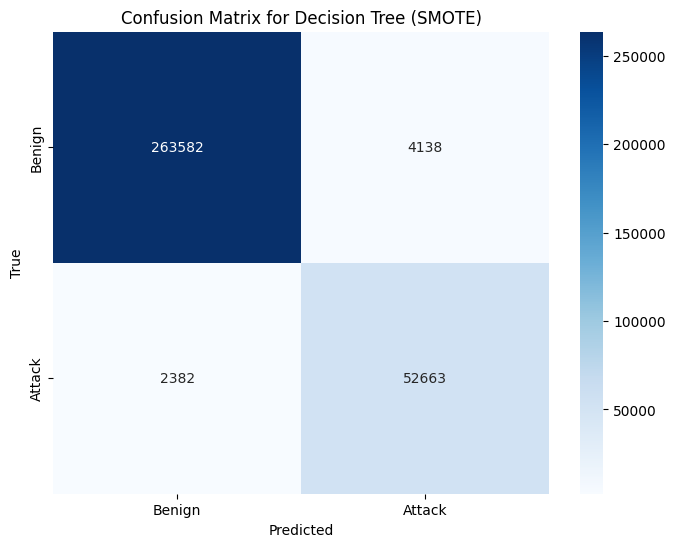

Metrics by Label (SMOTE):
                       Label  Accuracy Method
0                     Benign  0.984544  SMOTE
1              Infilteration  0.263636  SMOTE
2     DDoS attacks-LOIC-HTTP  0.999827  SMOTE
3   DoS attacks-SlowHTTPTest  1.000000  SMOTE
4           DDOS attack-HOIC  1.000000  SMOTE
5           DoS attacks-Hulk  0.999892  SMOTE
6             FTP-BruteForce  1.000000  SMOTE
7      DoS attacks-Slowloris  0.990521  SMOTE
8             SSH-Bruteforce  0.999733  SMOTE
9      DoS attacks-GoldenEye  0.997628  SMOTE
10                       Bot  0.995828  SMOTE
11      DDOS attack-LOIC-UDP  1.000000  SMOTE
12          Brute Force -XSS  1.000000  SMOTE
13          Brute Force -Web  0.909091  SMOTE
14             SQL Injection  1.000000  SMOTE


In [31]:
# Predict and evaluate on the test set
dt_metrics["smote"] = test_metrics("Decision Tree", decision_tree_model_smote, "SMOTE", scaler_smote)

In [32]:
decision_tree_model_adasyn = DecisionTreeClassifier()
decision_tree_model_adasyn.fit(scaler_adasyn.transform(X_adasyn_train), Y_adasyn_train.is_attack)

DecisionTreeClassifier()

Decision Tree with ADASYN Test Set Performance
Classification Report (Test Decision Tree (ADASYN)):
              precision    recall  f1-score   support

           0     0.9895    0.9870    0.9883    267720
           1     0.9377    0.9489    0.9433     55045

    accuracy                         0.9805    322765
   macro avg     0.9636    0.9680    0.9658    322765
weighted avg     0.9806    0.9805    0.9806    322765

Accuracy: 0.9805369231484207
Precision: 0.9806424536554045
Recall: 0.9805369231484207
F1 Score: 0.9805827685100714
AUC: 0.9679766108131216


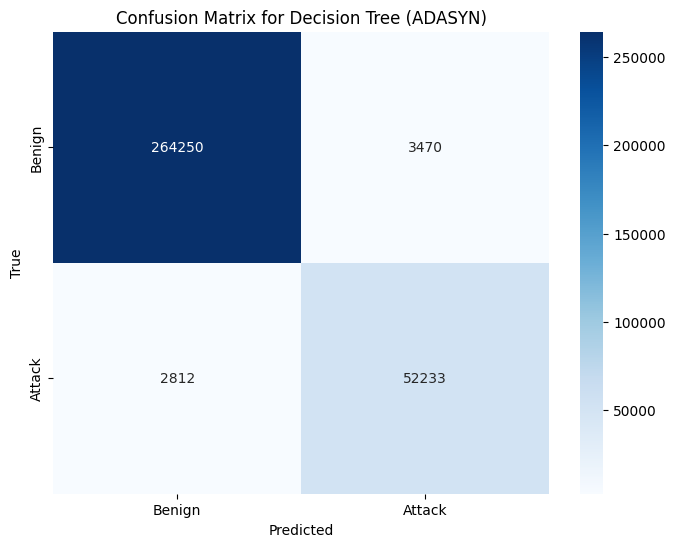

Metrics by Label (ADASYN):
                       Label  Accuracy  Method
0                     Benign  0.987039  ADASYN
1              Infilteration  0.126959  ADASYN
2     DDoS attacks-LOIC-HTTP  0.999740  ADASYN
3   DoS attacks-SlowHTTPTest  1.000000  ADASYN
4           DDOS attack-HOIC  1.000000  ADASYN
5           DoS attacks-Hulk  1.000000  ADASYN
6             FTP-BruteForce  1.000000  ADASYN
7      DoS attacks-Slowloris  0.990521  ADASYN
8             SSH-Bruteforce  0.999733  ADASYN
9      DoS attacks-GoldenEye  1.000000  ADASYN
10                       Bot  0.996871  ADASYN
11      DDOS attack-LOIC-UDP  1.000000  ADASYN
12          Brute Force -XSS  0.600000  ADASYN
13          Brute Force -Web  0.909091  ADASYN
14             SQL Injection  1.000000  ADASYN


In [33]:
# Predict and evaluate on the test set
dt_metrics["adasyn"] = test_metrics("Decision Tree", decision_tree_model_adasyn, "ADASYN", scaler_adasyn)

In [34]:
# Combine metrics into one DataFrame for Decision Tree
combined_metrics_dt = pd.concat([dt_metrics["adasyn"][1], dt_metrics["original"][1], dt_metrics["random"][1], dt_metrics["smote"][1]])
# Pivot the table to get accuracy for each method as columns in the specified order
accuracy_pivot_dt = combined_metrics_dt.pivot(index='Label', columns='Method', values='Accuracy')
accuracy_pivot_dt = accuracy_pivot_dt[['Original', 'Random Oversampling', 'SMOTE', 'ADASYN']]
print("Accuracy by Label and Method (Decision Tree):")
print(accuracy_pivot_dt)

Accuracy by Label and Method (Decision Tree):
Method                    Original  Random Oversampling     SMOTE    ADASYN
Label                                                                      
Benign                    0.992851             0.983072  0.984544  0.987039
Bot                       0.994089             0.996523  0.995828  0.996871
Brute Force -Web          0.727273             0.727273  0.909091  0.909091
Brute Force -XSS          1.000000             0.600000  1.000000  0.600000
DDOS attack-HOIC          1.000000             0.999927  1.000000  1.000000
DDOS attack-LOIC-UDP      1.000000             1.000000  1.000000  1.000000
DDoS attacks-LOIC-HTTP    0.999480             0.999827  0.999827  0.999740
DoS attacks-GoldenEye     1.000000             0.997628  0.997628  1.000000
DoS attacks-Hulk          1.000000             0.999892  0.999892  1.000000
DoS attacks-SlowHTTPTest  1.000000             1.000000  1.000000  1.000000
DoS attacks-Slowloris     0.985782        

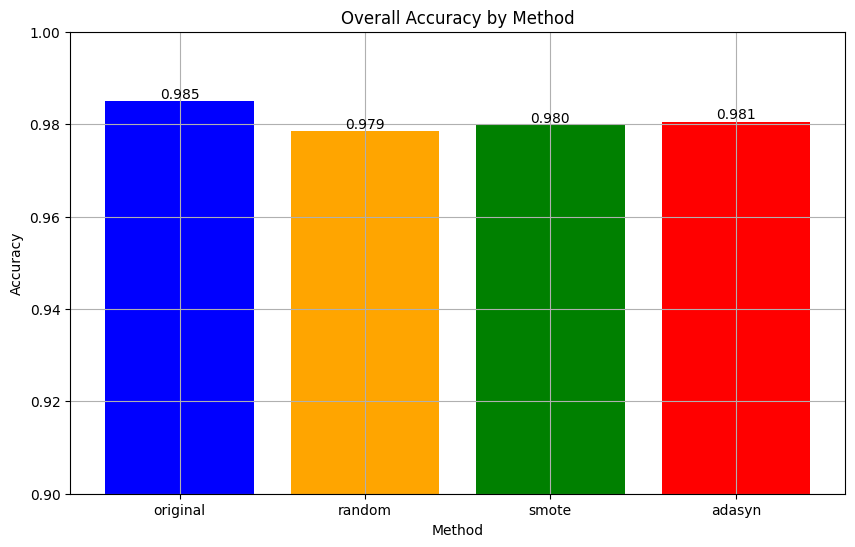

In [35]:
plot_overall_accuracy(dt_metrics)

### Random Forest

In [36]:
rf_metrics = {}

In [37]:
rf_model = RandomForestClassifier(verbose=1, n_jobs=-1)
rf_model.fit(scaler.transform(X_train), Y_train.is_attack)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


RandomForestClassifier(n_jobs=-1, verbose=1)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Random Forest with Original Test Set Performance


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.6s finished


Classification Report (Test Random Forest (Original)):
              precision    recall  f1-score   support

           0     0.9885    0.9984    0.9934    267720
           1     0.9919    0.9433    0.9670     55045

    accuracy                         0.9890    322765
   macro avg     0.9902    0.9709    0.9802    322765
weighted avg     0.9891    0.9890    0.9889    322765

Accuracy: 0.9890291698294424
Precision: 0.9890581866395656
Recall: 0.9890291698294424
F1 Score: 0.9889189040245666
AUC: 0.9708804978939782


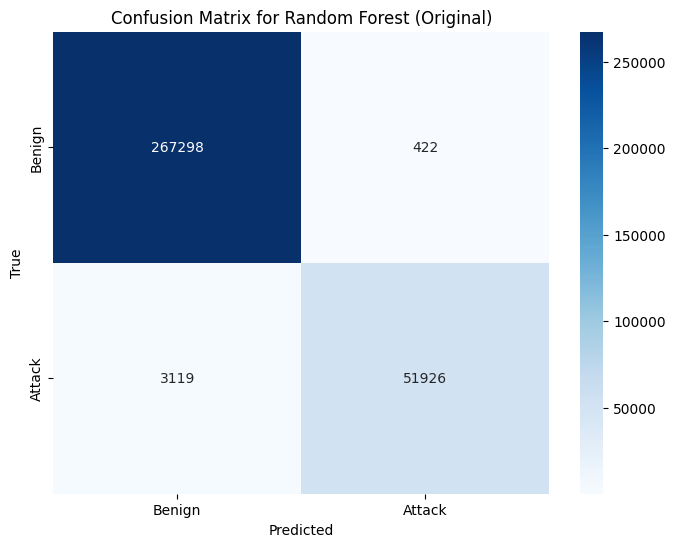

Metrics by Label (Original):
                       Label  Accuracy    Method
0                     Benign  0.998424  Original
1              Infilteration  0.038871  Original
2     DDoS attacks-LOIC-HTTP  0.999480  Original
3   DoS attacks-SlowHTTPTest  1.000000  Original
4           DDOS attack-HOIC  0.998983  Original
5           DoS attacks-Hulk  1.000000  Original
6             FTP-BruteForce  1.000000  Original
7      DoS attacks-Slowloris  0.985782  Original
8             SSH-Bruteforce  1.000000  Original
9      DoS attacks-GoldenEye  1.000000  Original
10                       Bot  0.996523  Original
11      DDOS attack-LOIC-UDP  1.000000  Original
12          Brute Force -XSS  0.400000  Original
13          Brute Force -Web  0.454545  Original
14             SQL Injection  0.500000  Original


In [38]:
# Predict and evaluate on the test set
rf_metrics["original"] = test_metrics("Random Forest", rf_model, "Original", scaler)

In [39]:
rf_model_random = RandomForestClassifier(verbose=1, n_jobs=-1)
rf_model_random.fit(scaler_random.transform(X_random_train), Y_random_train.is_attack)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished


RandomForestClassifier(n_jobs=-1, verbose=1)

Random Forest with Random Oversampling Test Set Performance


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.7s finished


Classification Report (Test Random Forest (Random Oversampling)):
              precision    recall  f1-score   support

           0     0.9908    0.9904    0.9906    267720
           1     0.9535    0.9553    0.9544     55045

    accuracy                         0.9844    322765
   macro avg     0.9722    0.9728    0.9725    322765
weighted avg     0.9844    0.9844    0.9844    322765

Accuracy: 0.9844313974563537
Precision: 0.9844428250568421
Recall: 0.9844313974563537
F1 Score: 0.9844369517688369
AUC: 0.97284254592398


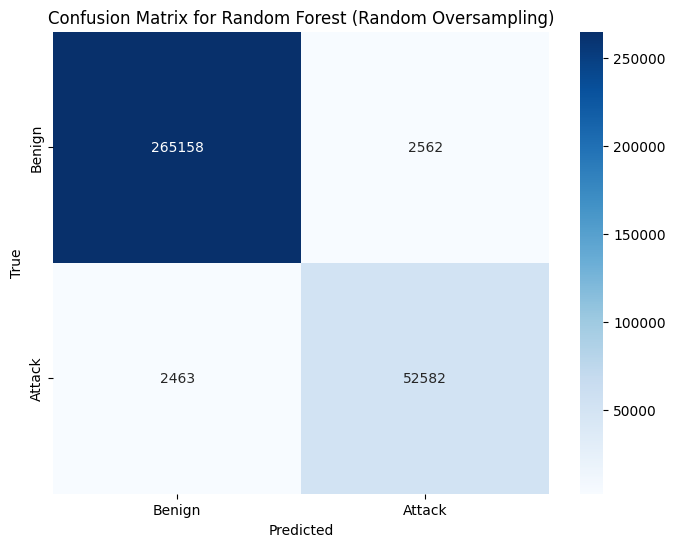

Metrics by Label (Random Oversampling):
                       Label  Accuracy               Method
0                     Benign  0.990430  Random Oversampling
1              Infilteration  0.236677  Random Oversampling
2     DDoS attacks-LOIC-HTTP  0.999567  Random Oversampling
3   DoS attacks-SlowHTTPTest  1.000000  Random Oversampling
4           DDOS attack-HOIC  0.999637  Random Oversampling
5           DoS attacks-Hulk  1.000000  Random Oversampling
6             FTP-BruteForce  1.000000  Random Oversampling
7      DoS attacks-Slowloris  0.990521  Random Oversampling
8             SSH-Bruteforce  1.000000  Random Oversampling
9      DoS attacks-GoldenEye  0.998814  Random Oversampling
10                       Bot  0.998261  Random Oversampling
11      DDOS attack-LOIC-UDP  1.000000  Random Oversampling
12          Brute Force -XSS  0.600000  Random Oversampling
13          Brute Force -Web  0.727273  Random Oversampling
14             SQL Injection  1.000000  Random Oversampling


In [40]:
# Predict and evaluate on the test set
rf_metrics["random"] = test_metrics("Random Forest", rf_model_random, "Random Oversampling", scaler_random)

In [41]:
rf_model_smote = RandomForestClassifier(verbose=1, n_jobs=-1)
rf_model_smote.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished


RandomForestClassifier(n_jobs=-1, verbose=1)

Random Forest with SMOTE Test Set Performance


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.8s finished


Classification Report (Test Random Forest (SMOTE)):
              precision    recall  f1-score   support

           0     0.9910    0.9913    0.9911    267720
           1     0.9575    0.9561    0.9568     55045

    accuracy                         0.9853    322765
   macro avg     0.9743    0.9737    0.9740    322765
weighted avg     0.9853    0.9853    0.9853    322765

Accuracy: 0.9852834105308816
Precision: 0.9852751162845133
Recall: 0.9852834105308816
F1 Score: 0.9852791587675938
AUC: 0.9737025032233586


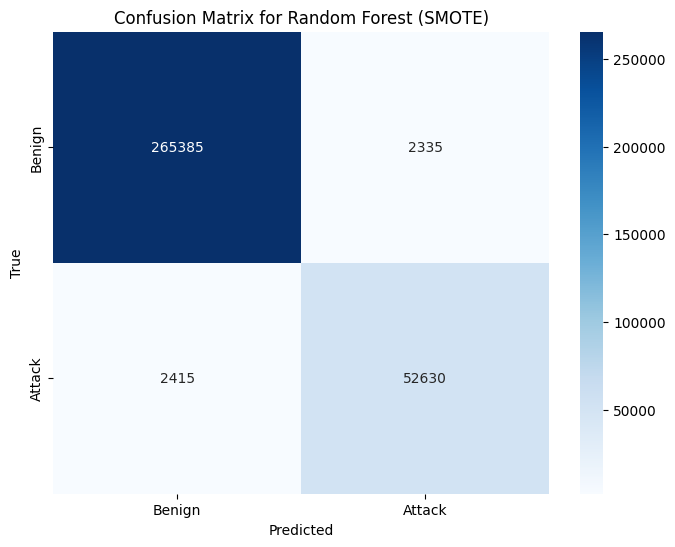

Metrics by Label (SMOTE):
                       Label  Accuracy Method
0                     Benign  0.991278  SMOTE
1              Infilteration  0.250470  SMOTE
2     DDoS attacks-LOIC-HTTP  0.999567  SMOTE
3   DoS attacks-SlowHTTPTest  1.000000  SMOTE
4           DDOS attack-HOIC  0.999637  SMOTE
5           DoS attacks-Hulk  1.000000  SMOTE
6             FTP-BruteForce  1.000000  SMOTE
7      DoS attacks-Slowloris  0.990521  SMOTE
8             SSH-Bruteforce  1.000000  SMOTE
9      DoS attacks-GoldenEye  1.000000  SMOTE
10                       Bot  0.998088  SMOTE
11      DDOS attack-LOIC-UDP  1.000000  SMOTE
12          Brute Force -XSS  1.000000  SMOTE
13          Brute Force -Web  0.909091  SMOTE
14             SQL Injection  1.000000  SMOTE


In [42]:
# Predict and evaluate on the test set
rf_metrics["smote"] = test_metrics("Random Forest", rf_model_smote, "SMOTE", scaler_smote)

In [43]:
rf_model_adasyn = RandomForestClassifier(verbose=1, n_jobs=-1)
rf_model_adasyn.fit(scaler_adasyn.transform(X_adasyn_train), Y_adasyn_train.is_attack)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished


RandomForestClassifier(n_jobs=-1, verbose=1)

Random Forest with ADASYN Test Set Performance


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.9s finished


Classification Report (Test Random Forest (ADASYN)):
              precision    recall  f1-score   support

           0     0.9894    0.9924    0.9909    267720
           1     0.9623    0.9485    0.9554     55045

    accuracy                         0.9849    322765
   macro avg     0.9759    0.9704    0.9731    322765
weighted avg     0.9848    0.9849    0.9848    322765

Accuracy: 0.9848899354019178
Precision: 0.9848235172635171
Recall: 0.9848899354019178
F1 Score: 0.9848464039241067
AUC: 0.9704418721791497


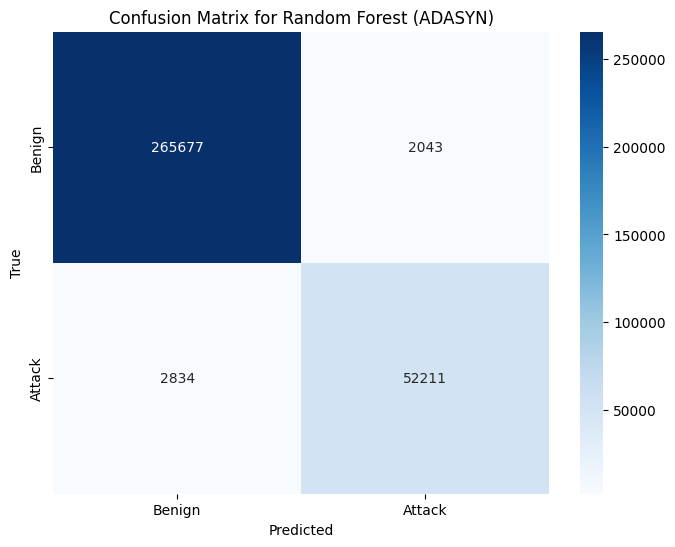

Metrics by Label (ADASYN):
                       Label  Accuracy  Method
0                     Benign  0.992369  ADASYN
1              Infilteration  0.114420  ADASYN
2     DDoS attacks-LOIC-HTTP  0.999567  ADASYN
3   DoS attacks-SlowHTTPTest  1.000000  ADASYN
4           DDOS attack-HOIC  1.000000  ADASYN
5           DoS attacks-Hulk  1.000000  ADASYN
6             FTP-BruteForce  1.000000  ADASYN
7      DoS attacks-Slowloris  1.000000  ADASYN
8             SSH-Bruteforce  0.999733  ADASYN
9      DoS attacks-GoldenEye  1.000000  ADASYN
10                       Bot  0.999652  ADASYN
11      DDOS attack-LOIC-UDP  1.000000  ADASYN
12          Brute Force -XSS  1.000000  ADASYN
13          Brute Force -Web  0.909091  ADASYN
14             SQL Injection  1.000000  ADASYN


In [44]:
# Predict and evaluate on the test set
rf_metrics["adasyn"] = test_metrics("Random Forest", rf_model_adasyn, "ADASYN", scaler_adasyn)

In [45]:
# Combine metrics into one DataFrame
combined_metrics_rf = pd.concat([rf_metrics["adasyn"][1], rf_metrics["original"][1], rf_metrics["random"][1], rf_metrics["smote"][1]])
# Pivot the table to get accuracy for each method as columns in the specified order
accuracy_pivot_rf = combined_metrics_rf.pivot(index='Label', columns='Method', values='Accuracy')
accuracy_pivot_rf = accuracy_pivot_rf[['Original', 'Random Oversampling', 'SMOTE', 'ADASYN']]
print("Accuracy by Label and Method:")
print(accuracy_pivot_rf)

Accuracy by Label and Method:
Method                    Original  Random Oversampling     SMOTE    ADASYN
Label                                                                      
Benign                    0.998424             0.990430  0.991278  0.992369
Bot                       0.996523             0.998261  0.998088  0.999652
Brute Force -Web          0.454545             0.727273  0.909091  0.909091
Brute Force -XSS          0.400000             0.600000  1.000000  1.000000
DDOS attack-HOIC          0.998983             0.999637  0.999637  1.000000
DDOS attack-LOIC-UDP      1.000000             1.000000  1.000000  1.000000
DDoS attacks-LOIC-HTTP    0.999480             0.999567  0.999567  0.999567
DoS attacks-GoldenEye     1.000000             0.998814  1.000000  1.000000
DoS attacks-Hulk          1.000000             1.000000  1.000000  1.000000
DoS attacks-SlowHTTPTest  1.000000             1.000000  1.000000  1.000000
DoS attacks-Slowloris     0.985782             0.990521  0

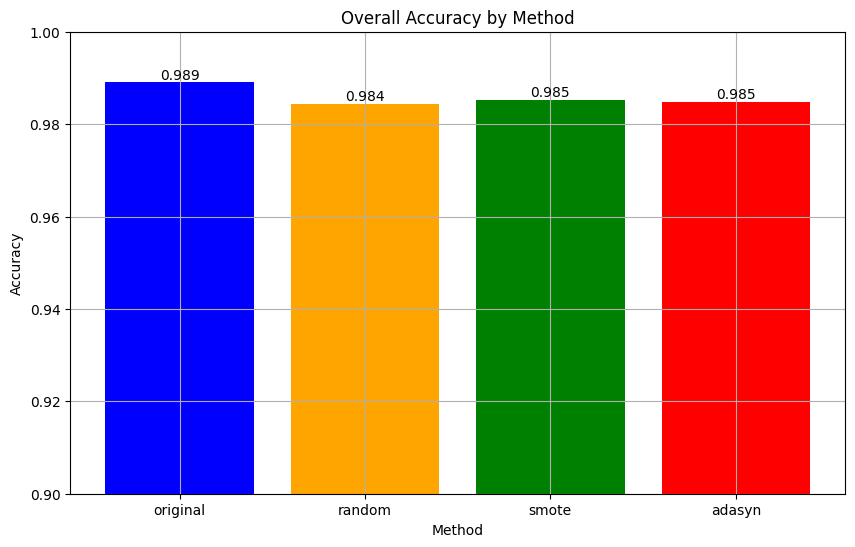

In [46]:
plot_overall_accuracy(rf_metrics)

### Adaboost

In [47]:
ada_metrics = {}

In [48]:
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier(algorithm='SAMME')
ada_model.fit(scaler.transform(X_train), Y_train.is_attack)

AdaBoostClassifier(algorithm='SAMME')

AdaBoost with Original Test Set Performance
Classification Report (Test AdaBoost (Original)):
              precision    recall  f1-score   support

           0     0.9808    0.9912    0.9860    267720
           1     0.9548    0.9057    0.9296     55045

    accuracy                         0.9766    322765
   macro avg     0.9678    0.9485    0.9578    322765
weighted avg     0.9764    0.9766    0.9764    322765

Accuracy: 0.9766145647762304
Precision: 0.976386627552671
Recall: 0.9766145647762304
F1 Score: 0.9763673533139493
AUC: 0.9484528987916205


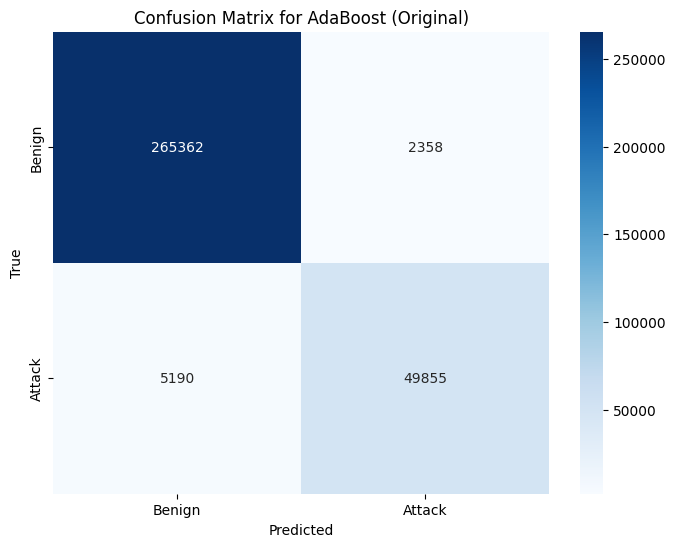

Metrics by Label (Original):
                       Label  Accuracy    Method
0                     Benign  0.991192  Original
1              Infilteration  0.033856  Original
2     DDoS attacks-LOIC-HTTP  0.903433  Original
3   DoS attacks-SlowHTTPTest  1.000000  Original
4           DDOS attack-HOIC  0.999055  Original
5           DoS attacks-Hulk  0.963935  Original
6             FTP-BruteForce  1.000000  Original
7      DoS attacks-Slowloris  0.492891  Original
8             SSH-Bruteforce  1.000000  Original
9      DoS attacks-GoldenEye  0.952550  Original
10                       Bot  0.921940  Original
11      DDOS attack-LOIC-UDP  0.000000  Original
12          Brute Force -XSS  0.200000  Original
13          Brute Force -Web  0.000000  Original
14             SQL Injection  0.000000  Original


In [49]:
# Predict and evaluate on the test set
ada_metrics["original"] = test_metrics("AdaBoost", ada_model, "Original", scaler)

In [50]:
ada_model_random = AdaBoostClassifier(algorithm='SAMME')
ada_model_random.fit(scaler_random.transform(X_random_train), Y_random_train.is_attack)

AdaBoostClassifier(algorithm='SAMME')

AdaBoost with Random Oversampling Test Set Performance
Classification Report (Test AdaBoost (Random Oversampling)):
              precision    recall  f1-score   support

           0     0.9901    0.8878    0.9362    267720
           1     0.6369    0.9568    0.7647     55045

    accuracy                         0.8996    322765
   macro avg     0.8135    0.9223    0.8505    322765
weighted avg     0.9299    0.8996    0.9069    322765

Accuracy: 0.8995925828389075
Precision: 0.9298571832351336
Recall: 0.8995925828389075
F1 Score: 0.9069375754735581
AUC: 0.9223219918052732


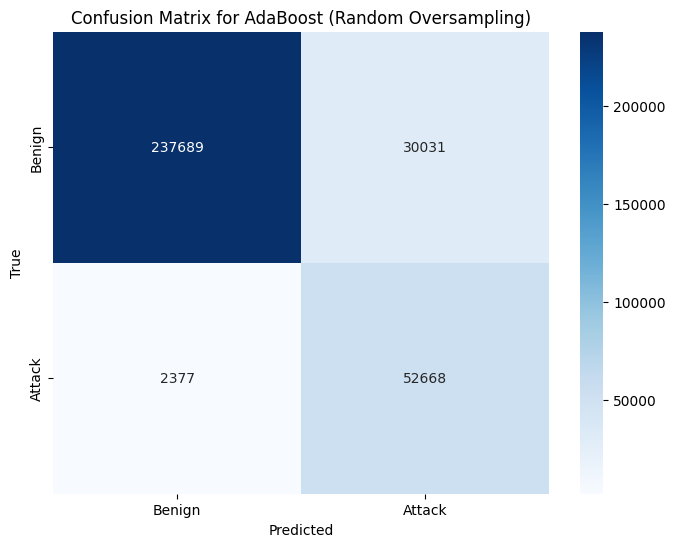

Metrics by Label (Random Oversampling):
                       Label  Accuracy               Method
0                     Benign  0.887827  Random Oversampling
1              Infilteration  0.321003  Random Oversampling
2     DDoS attacks-LOIC-HTTP  0.987084  Random Oversampling
3   DoS attacks-SlowHTTPTest  1.000000  Random Oversampling
4           DDOS attack-HOIC  1.000000  Random Oversampling
5           DoS attacks-Hulk  0.995897  Random Oversampling
6             FTP-BruteForce  1.000000  Random Oversampling
7      DoS attacks-Slowloris  0.990521  Random Oversampling
8             SSH-Bruteforce  1.000000  Random Oversampling
9      DoS attacks-GoldenEye  1.000000  Random Oversampling
10                       Bot  0.996175  Random Oversampling
11      DDOS attack-LOIC-UDP  1.000000  Random Oversampling
12          Brute Force -XSS  1.000000  Random Oversampling
13          Brute Force -Web  1.000000  Random Oversampling
14             SQL Injection  1.000000  Random Oversampling


In [51]:
# Predict and evaluate on the test set
ada_metrics["random"] = test_metrics("AdaBoost", ada_model_random, "Random Oversampling", scaler_random)

In [52]:
ada_model_smote = AdaBoostClassifier(algorithm='SAMME')
ada_model_smote.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack)

AdaBoostClassifier(algorithm='SAMME')

AdaBoost with SMOTE Test Set Performance
Classification Report (Test AdaBoost (SMOTE)):
              precision    recall  f1-score   support

           0     0.9876    0.9248    0.9551    267720
           1     0.7205    0.9436    0.8171     55045

    accuracy                         0.9280    322765
   macro avg     0.8541    0.9342    0.8861    322765
weighted avg     0.9421    0.9280    0.9316    322765

Accuracy: 0.9279630691060059
Precision: 0.9420621731158026
Recall: 0.9279630691060059
F1 Score: 0.9316067271988271
AUC: 0.9341634568456867


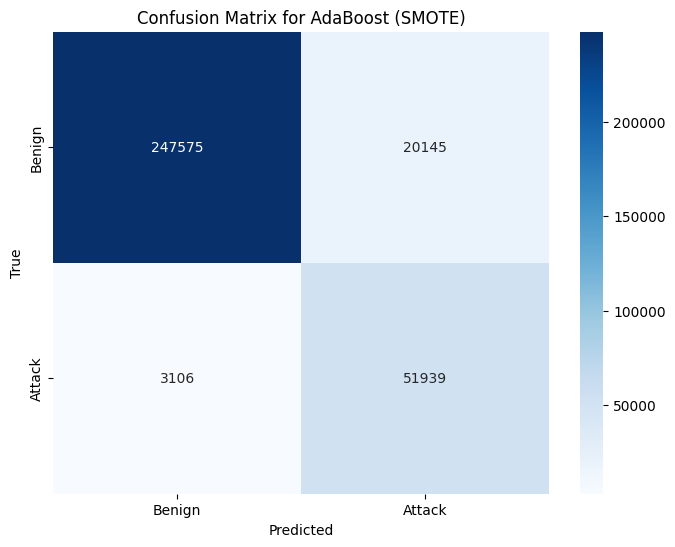

Metrics by Label (SMOTE):
                       Label  Accuracy Method
0                     Benign  0.924753  SMOTE
1              Infilteration  0.274922  SMOTE
2     DDoS attacks-LOIC-HTTP  0.964893  SMOTE
3   DoS attacks-SlowHTTPTest  1.000000  SMOTE
4           DDOS attack-HOIC  1.000000  SMOTE
5           DoS attacks-Hulk  0.994493  SMOTE
6             FTP-BruteForce  1.000000  SMOTE
7      DoS attacks-Slowloris  0.990521  SMOTE
8             SSH-Bruteforce  1.000000  SMOTE
9      DoS attacks-GoldenEye  1.000000  SMOTE
10                       Bot  0.941759  SMOTE
11      DDOS attack-LOIC-UDP  1.000000  SMOTE
12          Brute Force -XSS  1.000000  SMOTE
13          Brute Force -Web  1.000000  SMOTE
14             SQL Injection  1.000000  SMOTE


In [53]:
# Predict and evaluate on the test set
ada_metrics["smote"] = test_metrics("AdaBoost", ada_model_smote, "SMOTE", scaler_smote)

In [54]:
ada_model_adasyn = AdaBoostClassifier(algorithm='SAMME')
ada_model_adasyn.fit(scaler_adasyn.transform(X_adasyn_train), Y_adasyn_train.is_attack)

AdaBoostClassifier(algorithm='SAMME')

AdaBoost with ADASYN Test Set Performance
Classification Report (Test AdaBoost (ADASYN)):
              precision    recall  f1-score   support

           0     0.9902    0.8342    0.9055    267720
           1     0.5434    0.9597    0.6939     55045

    accuracy                         0.8556    322765
   macro avg     0.7668    0.8969    0.7997    322765
weighted avg     0.9140    0.8556    0.8694    322765

Accuracy: 0.8555915294409245
Precision: 0.9139670696729038
Recall: 0.8555915294409245
F1 Score: 0.8694168248179279
AUC: 0.8969381165013148


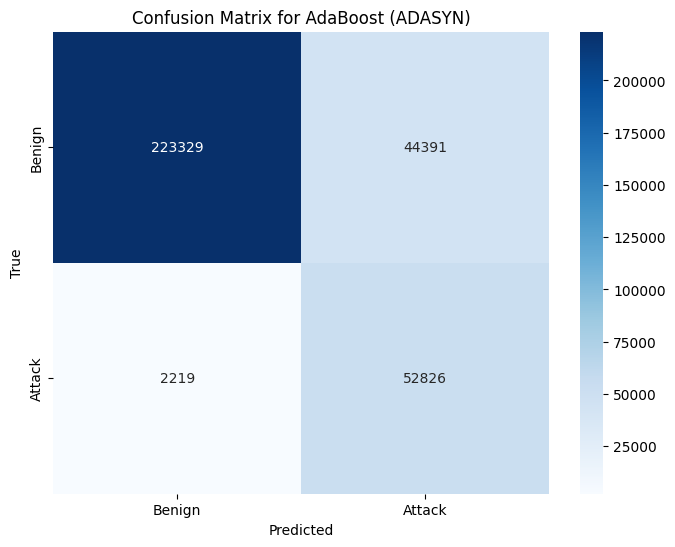

Metrics by Label (ADASYN):
                       Label  Accuracy  Method
0                     Benign  0.834189  ADASYN
1              Infilteration  0.345455  ADASYN
2     DDoS attacks-LOIC-HTTP  0.999567  ADASYN
3   DoS attacks-SlowHTTPTest  1.000000  ADASYN
4           DDOS attack-HOIC  0.999782  ADASYN
5           DoS attacks-Hulk  0.996869  ADASYN
6             FTP-BruteForce  1.000000  ADASYN
7      DoS attacks-Slowloris  1.000000  ADASYN
8             SSH-Bruteforce  1.000000  ADASYN
9      DoS attacks-GoldenEye  1.000000  ADASYN
10                       Bot  0.983658  ADASYN
11      DDOS attack-LOIC-UDP  1.000000  ADASYN
12          Brute Force -XSS  1.000000  ADASYN
13          Brute Force -Web  1.000000  ADASYN
14             SQL Injection  1.000000  ADASYN


In [55]:
# Predict and evaluate on the test set
ada_metrics["adasyn"] = test_metrics("AdaBoost", ada_model_adasyn, "ADASYN", scaler_adasyn)

In [56]:
# Combine metrics into one DataFrame
combined_metrics_ada = pd.concat([ada_metrics["adasyn"][1], ada_metrics["original"][1], ada_metrics["random"][1], ada_metrics["smote"][1]])

# Pivot the table to get accuracy for each method as columns in the specified order
accuracy_pivot_ada = combined_metrics_ada.pivot(index='Label', columns='Method', values='Accuracy')
accuracy_pivot_ada = accuracy_pivot_ada[['Original', 'Random Oversampling', 'SMOTE', 'ADASYN']]
print("Accuracy by Label and Method (AdaBoost):")
print(accuracy_pivot_ada)

Accuracy by Label and Method (AdaBoost):
Method                    Original  Random Oversampling     SMOTE    ADASYN
Label                                                                      
Benign                    0.991192             0.887827  0.924753  0.834189
Bot                       0.921940             0.996175  0.941759  0.983658
Brute Force -Web          0.000000             1.000000  1.000000  1.000000
Brute Force -XSS          0.200000             1.000000  1.000000  1.000000
DDOS attack-HOIC          0.999055             1.000000  1.000000  0.999782
DDOS attack-LOIC-UDP      0.000000             1.000000  1.000000  1.000000
DDoS attacks-LOIC-HTTP    0.903433             0.987084  0.964893  0.999567
DoS attacks-GoldenEye     0.952550             1.000000  1.000000  1.000000
DoS attacks-Hulk          0.963935             0.995897  0.994493  0.996869
DoS attacks-SlowHTTPTest  1.000000             1.000000  1.000000  1.000000
DoS attacks-Slowloris     0.492891             

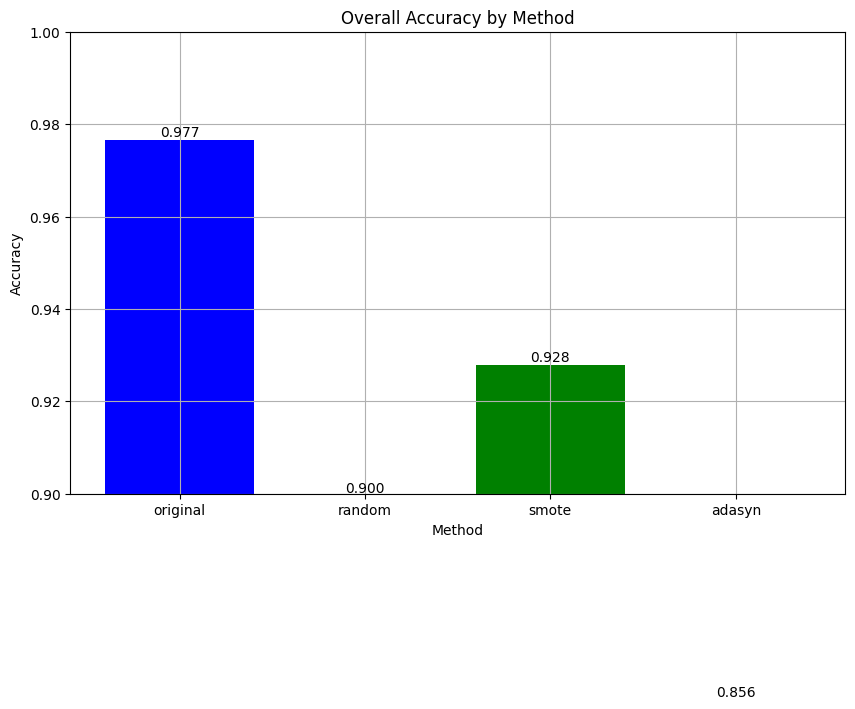

In [57]:
plot_overall_accuracy(ada_metrics)

### XGBoost

In [58]:
xgb_metrics = {}

In [59]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(n_jobs=-1)
xgb_model.fit(scaler.transform(X_train), Y_train.is_attack)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

XGBoost with Original Test Set Performance
Classification Report (Test XGBoost (Original)):
              precision    recall  f1-score   support

           0     0.9883    0.9993    0.9938    267720
           1     0.9966    0.9424    0.9687     55045

    accuracy                         0.9896    322765
   macro avg     0.9924    0.9709    0.9813    322765
weighted avg     0.9897    0.9896    0.9895    322765

Accuracy: 0.9896302263256549
Precision: 0.9897067559734463
Recall: 0.9896302263256549
F1 Score: 0.9895143083255388
AUC: 0.97088923987555


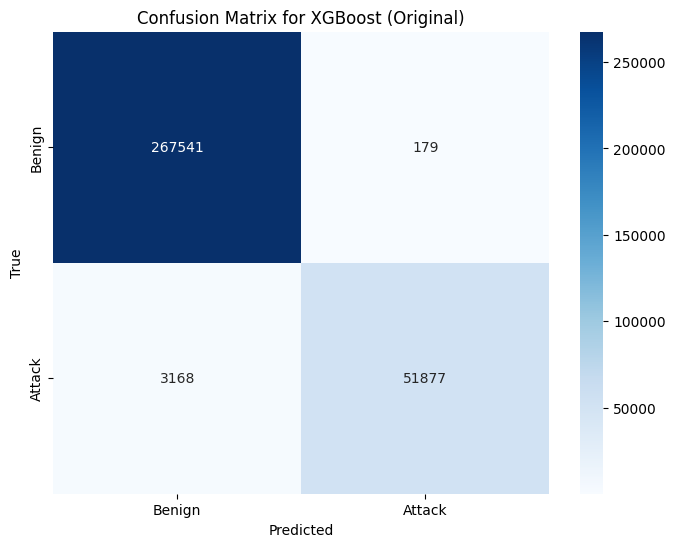

Metrics by Label (Original):
                       Label  Accuracy    Method
0                     Benign  0.999331  Original
1              Infilteration  0.021630  Original
2     DDoS attacks-LOIC-HTTP  0.999653  Original
3   DoS attacks-SlowHTTPTest  1.000000  Original
4           DDOS attack-HOIC  0.999927  Original
5           DoS attacks-Hulk  1.000000  Original
6             FTP-BruteForce  1.000000  Original
7      DoS attacks-Slowloris  0.985782  Original
8             SSH-Bruteforce  1.000000  Original
9      DoS attacks-GoldenEye  1.000000  Original
10                       Bot  0.995480  Original
11      DDOS attack-LOIC-UDP  1.000000  Original
12          Brute Force -XSS  0.600000  Original
13          Brute Force -Web  0.181818  Original
14             SQL Injection  0.000000  Original


In [60]:
# Predict and evaluate on the test set
# Original Dataset
xgb_metrics["original"] = test_metrics("XGBoost", xgb_model, "Original", scaler)

In [61]:
xgb_model_random = xgb.XGBClassifier(n_jobs=-1)
xgb_model_random.fit(scaler_random.transform(X_random_train), Y_random_train.is_attack)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

XGBoost with Random Oversampling Test Set Performance
Classification Report (Test XGBoost (Random Oversampling)):
              precision    recall  f1-score   support

           0     0.9914    0.9906    0.9910    267720
           1     0.9543    0.9582    0.9563     55045

    accuracy                         0.9850    322765
   macro avg     0.9729    0.9744    0.9736    322765
weighted avg     0.9851    0.9850    0.9851    322765

Accuracy: 0.9850479450993757
Precision: 0.9850734376545047
Recall: 0.9850479450993757
F1 Score: 0.9850598894695969
AUC: 0.9743759554157481


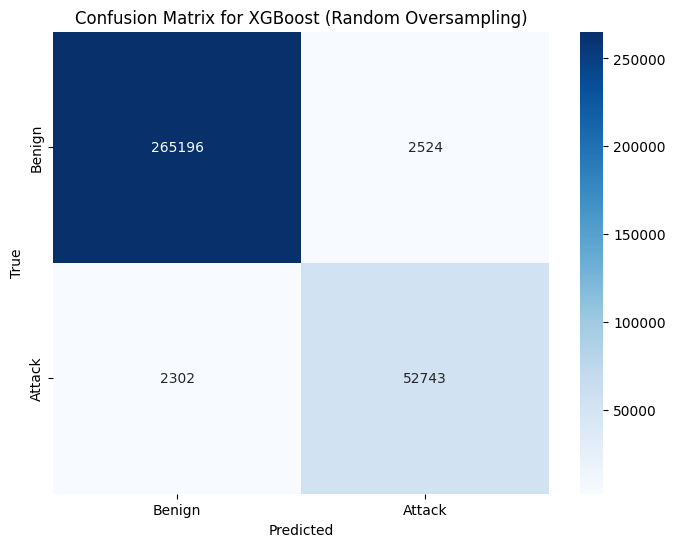

Metrics by Label (Random Oversampling):
                       Label  Accuracy               Method
0                     Benign  0.990572  Random Oversampling
1              Infilteration  0.290909  Random Oversampling
2     DDoS attacks-LOIC-HTTP  0.998006  Random Oversampling
3   DoS attacks-SlowHTTPTest  1.000000  Random Oversampling
4           DDOS attack-HOIC  1.000000  Random Oversampling
5           DoS attacks-Hulk  1.000000  Random Oversampling
6             FTP-BruteForce  1.000000  Random Oversampling
7      DoS attacks-Slowloris  0.995261  Random Oversampling
8             SSH-Bruteforce  1.000000  Random Oversampling
9      DoS attacks-GoldenEye  0.997628  Random Oversampling
10                       Bot  0.997740  Random Oversampling
11      DDOS attack-LOIC-UDP  1.000000  Random Oversampling
12          Brute Force -XSS  1.000000  Random Oversampling
13          Brute Force -Web  0.909091  Random Oversampling
14             SQL Injection  1.000000  Random Oversampling


In [62]:
# Predict and evaluate on the test set
# Random Oversampling
xgb_metrics["random"] = test_metrics("XGBoost", xgb_model_random, "Random Oversampling", scaler_random)

In [63]:
xgb_model_smote = xgb.XGBClassifier(n_jobs=-1)
xgb_model_smote.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

XGBoost with SMOTE Test Set Performance
Classification Report (Test XGBoost (SMOTE)):
              precision    recall  f1-score   support

           0     0.9909    0.9914    0.9912    267720
           1     0.9581    0.9558    0.9569     55045

    accuracy                         0.9853    322765
   macro avg     0.9745    0.9736    0.9740    322765
weighted avg     0.9853    0.9853    0.9853    322765

Accuracy: 0.9853298839713104
Precision: 0.9853165566101497
Recall: 0.9853298839713104
F1 Score: 0.9853229394729682
AUC: 0.9736006321899241


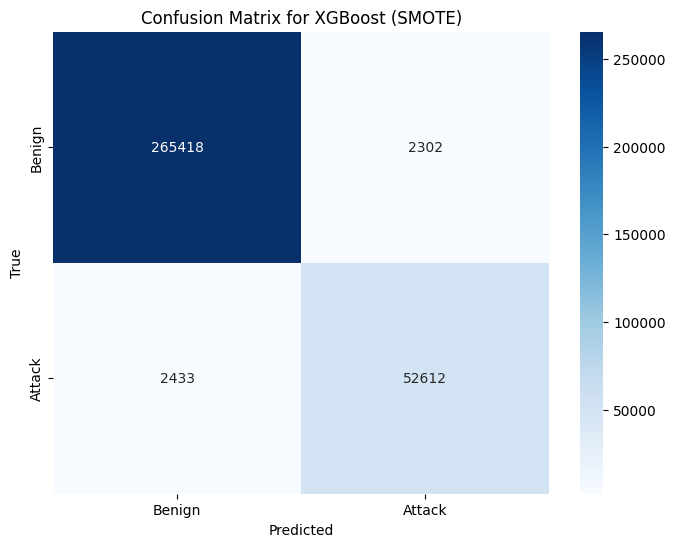

Metrics by Label (SMOTE):
                       Label  Accuracy Method
0                     Benign  0.991401  SMOTE
1              Infilteration  0.252038  SMOTE
2     DDoS attacks-LOIC-HTTP  0.997053  SMOTE
3   DoS attacks-SlowHTTPTest  1.000000  SMOTE
4           DDOS attack-HOIC  1.000000  SMOTE
5           DoS attacks-Hulk  1.000000  SMOTE
6             FTP-BruteForce  1.000000  SMOTE
7      DoS attacks-Slowloris  1.000000  SMOTE
8             SSH-Bruteforce  1.000000  SMOTE
9      DoS attacks-GoldenEye  1.000000  SMOTE
10                       Bot  0.997740  SMOTE
11      DDOS attack-LOIC-UDP  1.000000  SMOTE
12          Brute Force -XSS  1.000000  SMOTE
13          Brute Force -Web  1.000000  SMOTE
14             SQL Injection  1.000000  SMOTE


In [64]:
# Predict and evaluate on the test set
# SMOTE
xgb_metrics["smote"] = test_metrics("XGBoost", xgb_model_smote, "SMOTE", scaler_smote)

In [65]:
xgb_model_adasyn = xgb.XGBClassifier(n_jobs=-1)
xgb_model_adasyn.fit(scaler_adasyn.transform(X_adasyn_train), Y_adasyn_train.is_attack)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

XGBoost with ADASYN Test Set Performance
Classification Report (Test XGBoost (ADASYN)):
              precision    recall  f1-score   support

           0     0.9893    0.9937    0.9915    267720
           1     0.9689    0.9479    0.9583     55045

    accuracy                         0.9859    322765
   macro avg     0.9791    0.9708    0.9749    322765
weighted avg     0.9859    0.9859    0.9859    322765

Accuracy: 0.9859309404675228
Precision: 0.9858554993010592
Recall: 0.9859309404675228
F1 Score: 0.9858696180981803
AUC: 0.9708384861335557


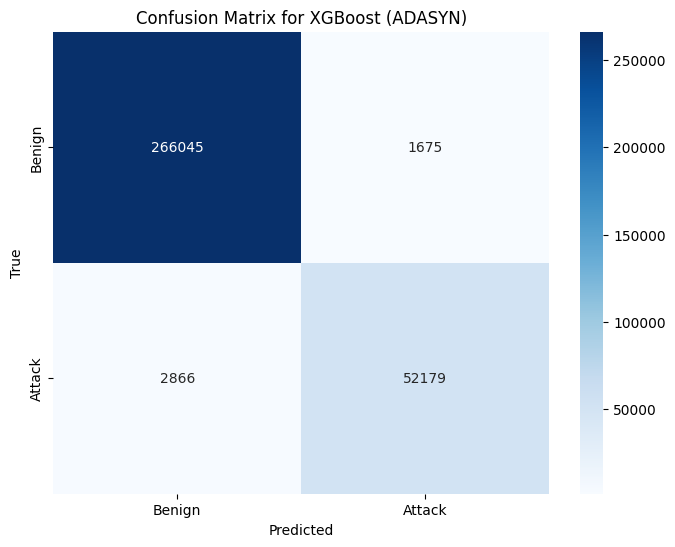

Metrics by Label (ADASYN):
                       Label  Accuracy  Method
0                     Benign  0.993743  ADASYN
1              Infilteration  0.114107  ADASYN
2     DDoS attacks-LOIC-HTTP  0.997053  ADASYN
3   DoS attacks-SlowHTTPTest  1.000000  ADASYN
4           DDOS attack-HOIC  1.000000  ADASYN
5           DoS attacks-Hulk  1.000000  ADASYN
6             FTP-BruteForce  1.000000  ADASYN
7      DoS attacks-Slowloris  1.000000  ADASYN
8             SSH-Bruteforce  0.999733  ADASYN
9      DoS attacks-GoldenEye  0.998814  ADASYN
10                       Bot  0.999305  ADASYN
11      DDOS attack-LOIC-UDP  1.000000  ADASYN
12          Brute Force -XSS  1.000000  ADASYN
13          Brute Force -Web  1.000000  ADASYN
14             SQL Injection  1.000000  ADASYN


In [66]:
# Predict and evaluate on the test set
# ADASYN
xgb_metrics["adasyn"] = test_metrics("XGBoost", xgb_model_adasyn, "ADASYN", scaler_adasyn)

In [67]:
# Combine metrics into one DataFrame
combined_metrics_xgb = pd.concat([xgb_metrics["adasyn"][1], xgb_metrics["original"][1], xgb_metrics["random"][1], xgb_metrics["smote"][1]])
# Pivot the table to get accuracy for each method as columns in the specified order
accuracy_pivot_xgb = combined_metrics_xgb.pivot(index='Label', columns='Method', values='Accuracy')
accuracy_pivot_xgb = accuracy_pivot_xgb[['Original', 'Random Oversampling', 'SMOTE', 'ADASYN']]
print("Accuracy by Label and Method:")
print(accuracy_pivot_xgb)

Accuracy by Label and Method:
Method                    Original  Random Oversampling     SMOTE    ADASYN
Label                                                                      
Benign                    0.999331             0.990572  0.991401  0.993743
Bot                       0.995480             0.997740  0.997740  0.999305
Brute Force -Web          0.181818             0.909091  1.000000  1.000000
Brute Force -XSS          0.600000             1.000000  1.000000  1.000000
DDOS attack-HOIC          0.999927             1.000000  1.000000  1.000000
DDOS attack-LOIC-UDP      1.000000             1.000000  1.000000  1.000000
DDoS attacks-LOIC-HTTP    0.999653             0.998006  0.997053  0.997053
DoS attacks-GoldenEye     1.000000             0.997628  1.000000  0.998814
DoS attacks-Hulk          1.000000             1.000000  1.000000  1.000000
DoS attacks-SlowHTTPTest  1.000000             1.000000  1.000000  1.000000
DoS attacks-Slowloris     0.985782             0.995261  1

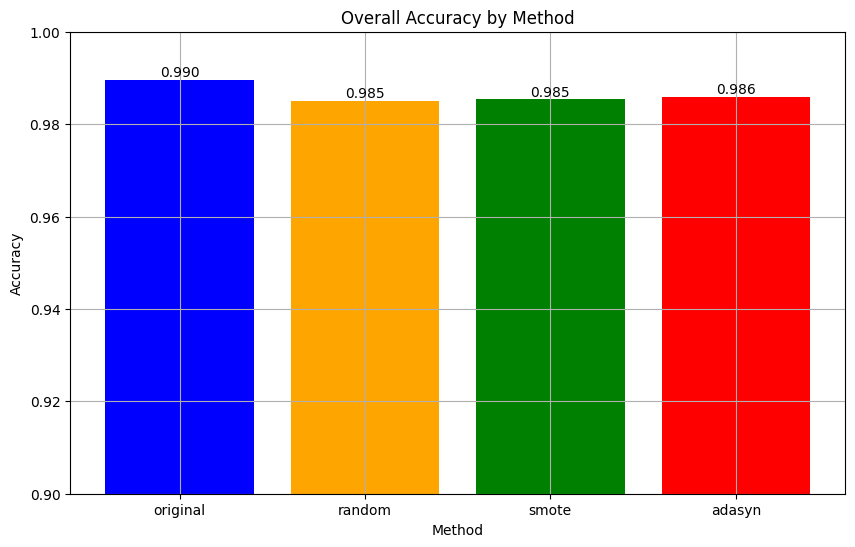

In [68]:
plot_overall_accuracy(xgb_metrics)